### Temi Note

## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.

Create 1 slide with informative visualization for each question. Explore data using SQL and Python but use Tableau for final visualization.

Don't limit your EDA to these 10 questions. Let's be creative :).

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from datetime import datetime
import os
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [135]:
import json
import requests

In [57]:
postgres_pwd=os.environ['LHL_DATABASE']

In [75]:
con = psycopg2.connect(database='mid_term_project', 
                       user='lhl_student',
                       password=postgres_pwd,
                       host='mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com',
                       port='5432')

query = con.cursor()

In [74]:
# query.close()

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [68]:
query.execute("""
select dep_delay
from flights
where dep_delay is not Null and fl_date LIKE '2018%' """)

response = query.fetchall()
cols1 = [column[0] for column in query.description]

In [69]:
delay18_dt=pd.DataFrame(response,columns= cols1)

In [76]:
query.execute(
"""
select dep_delay
from flights
where dep_delay is not Null and fl_date LIKE '2019%';
""")
response1 = query.fetchall()
cols1 = [column[0] for column in query.description]

In [77]:
delay19_dt=pd.DataFrame(response1,columns= cols1)

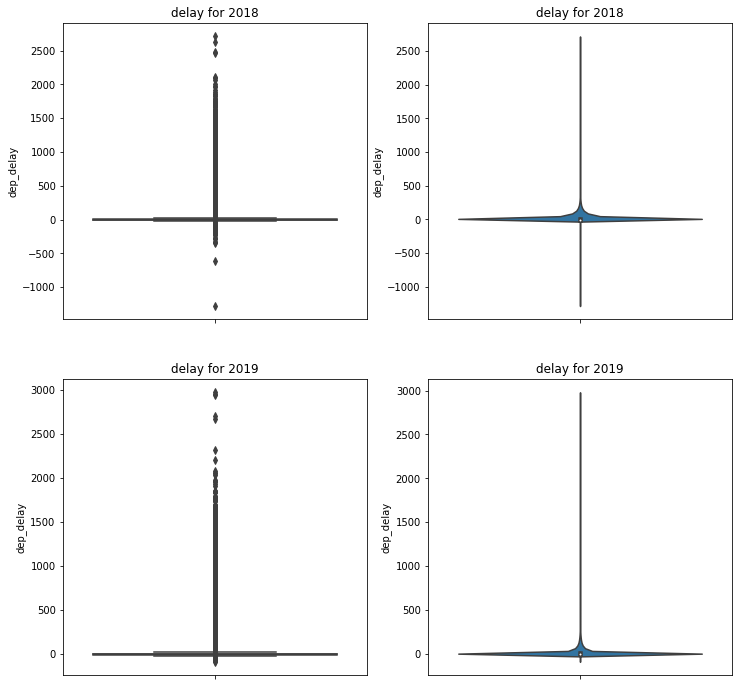

In [81]:
fig,((ax1, ax2),(ax3, ax4)) =plt.subplots(2,2,figsize=(12,12))
sns.boxplot(y=delay18_dt.dep_delay,ax=ax1).set_title('delay for 2018')
sns.violinplot(y=delay18_dt.dep_delay,ax=ax2).set_title('delay for 2018')
sns.boxplot(y=delay19_dt.dep_delay,ax=ax3).set_title('delay for 2019')
sns.violinplot(y=delay19_dt.dep_delay,ax=ax4).set_title('delay for 2019')
plt.show();

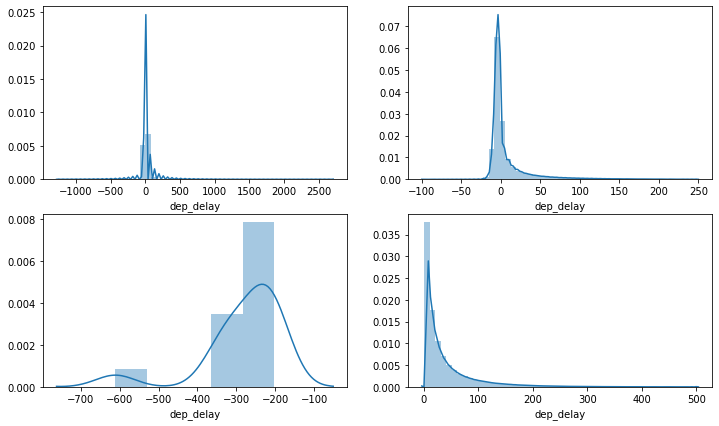

In [93]:
# using 2018 data due to the high data sample
fig,((ax1, ax2),(ax3, ax4)) =plt.subplots(2,2,figsize=(12,7))
sns.distplot(delay18_dt.dep_delay,ax=ax1)
sns.distplot(delay18_dt.dep_delay[(delay18_dt.dep_delay> -100) & (delay18_dt.dep_delay <250)],ax=ax2)
sns.distplot(delay18_dt.dep_delay[(delay18_dt.dep_delay> -1000) & (delay18_dt.dep_delay <-200)],ax=ax3)
sns.distplot(delay18_dt.dep_delay[(delay18_dt.dep_delay> 0) & (delay18_dt.dep_delay < 500)],ax=ax4)
plt.show();

In [94]:
delay18_dt.dep_delay[(delay18_dt.dep_delay> 0) & (delay18_dt.dep_delay < 500)].count()

2621344

In [132]:
# mu, sigma = 0, 0.1 # mean and standard deviation
# s = np.random.normal(mu, sigma, 1000)
# st.normaltest(s)

NormaltestResult(statistic=0.6276962526808141, pvalue=0.7306299831829932)

In [131]:
st.normaltest(delay18_dt['dep_delay'])
# from pvalue the data is from a Normal distribution.

NormaltestResult(statistic=11861319.22632992, pvalue=0.0)

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [6]:
f = pd.read_csv('exporate\delay_month.csv')

In [10]:
delay = f.sort_values(['Year','Month'],ignore_index= True)

In [30]:
month = delay.groupby('Month',as_index= False).agg({'avg':'mean'})
month.head()

,Month,avg
0,1,9.827812
1,2,11.737970
2,3,8.403554
3,4,9.356035
4,5,11.355161


In [45]:
WOearly = pd.read_csv('exporate\delay_withoutearly.csv')

In [100]:
# WOearly[WOearly.Year== 2018].sort_values('avg_delay',ascending=False)

In [102]:
WOearly.head()
# without early arrival

,date_trunc,Date,Year,Month,avg_delay,sum_delay,Nos_flight
0,2018-06-01 00:00:00+00,2018-06-01,2018,6,42.333918,10836975,255988
1,2019-11-01 00:00:00+00,2019-11-01,2019,11,35.773384,6769469,189232
2,2018-12-01 00:00:00+00,2018-12-01,2018,12,36.607714,8011891,218858
3,2019-03-01 00:00:00+00,2019-03-01,2019,3,37.913607,8455341,223016
4,2019-06-01 00:00:00+00,2019-06-01,2019,6,46.132093,12776237,276949


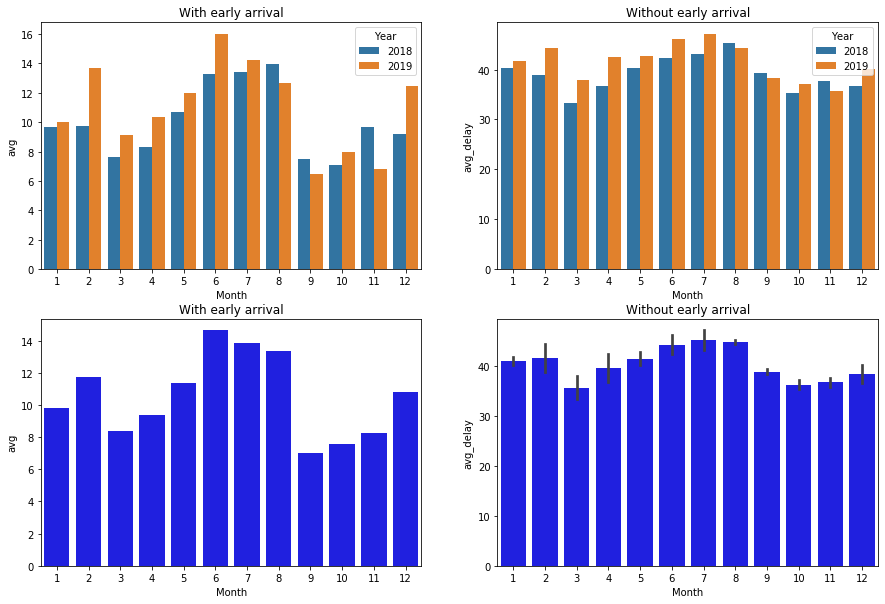

In [43]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10))
sns.barplot(x='Month',y='avg',hue='Year',data=delay,ax=ax1,).set_title('With early arrival')
sns.barplot(x='Month',y='avg',data=month,ax=ax3,color="blue").set_title('With early arrival')
sns.barplot(x='Month',y='avg_delay',hue='Year',data=WOearly,ax=ax2).set_title('Without early arrival')
sns.barplot(x='Month',y='avg_delay',data=WOearly,ax=ax4,color="blue").set_title('Without early arrival')
plt.show;

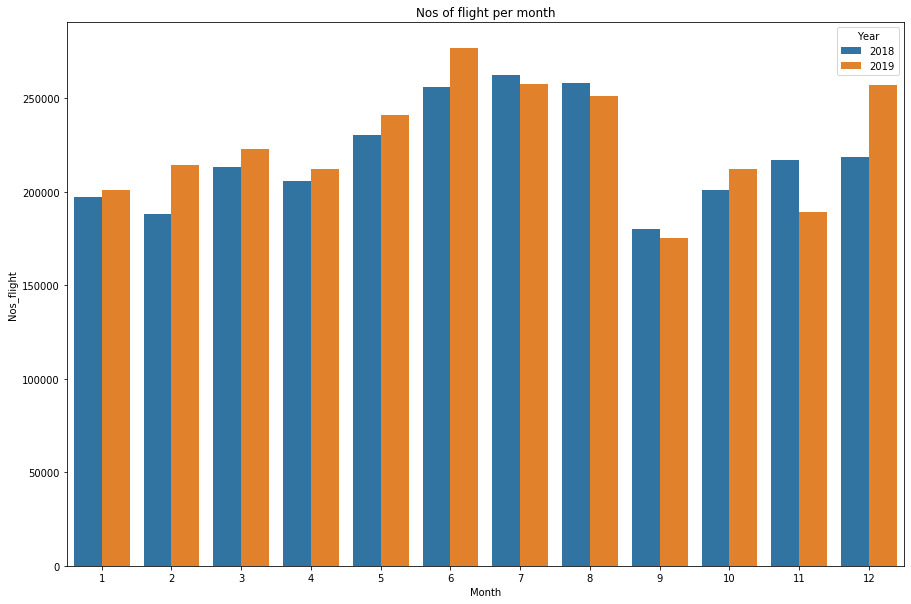

In [46]:
# that have delay
fig, (ax1) = plt.subplots(1,1,figsize=(15,10))
sns.barplot(x='Month',y='Nos_flight',hue='Year',data=WOearly,ax=ax1).set_title('Nos of flight per month')
plt.show;

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [104]:
# data as already been group by date ,origin,dest_city on sql for 2019
f = pd.read_csv('exporate\weather.csv')

In [122]:
query.execute("""
with t1 as (select fl_date,TO_DATE(fl_date,'YYYY-MM-DD'),crs_dep_time,dep_time,dep_delay,
            origin_city_name,dest_city_name,crs_arr_time
from flights
where  10 < dep_delay and dep_delay < 500)
select *,Date_trunc('month',to_date)
from t1
where Date_trunc('month',to_date) in ('2018-07-01','2018-06-01','2018-08-01','2018-01-01','2018-02-01')  """)

response_weat = query.fetchall()
cols2 = [column[0] for column in query.description]

In [ ]:
# choose Jan and Feb to account for snow

In [123]:
weather_dt=pd.DataFrame(response_weat,columns= cols2)

In [124]:
weather_dt=weather_dt.drop(columns='to_date')
weather_dt.date_trunc=pd.to_datetime(weather_dt['date_trunc'])
weather_dt.head()

,fl_date,crs_dep_time,dep_time,dep_delay,origin_city_name,dest_city_name,crs_arr_time,date_trunc
0,2018-07-01,708,720.0,12.0,"Rochester, NY","Charlotte, NC",910,2018-07-01 00:00:00+00:00
1,2018-07-01,2000,2018.0,18.0,"Washington, DC","Atlanta, GA",2205,2018-07-01 00:00:00+00:00
2,2018-07-01,2010,2031.0,21.0,"Washington, DC","Memphis, TN",2132,2018-07-01 00:00:00+00:00
3,2018-07-01,1519,1535.0,16.0,"Portland, ME","Philadelphia, PA",1704,2018-07-01 00:00:00+00:00
4,2018-07-01,1728,2017.0,169.0,"Nashville, TN","Miami, FL",2049,2018-07-01 00:00:00+00:00


In [128]:
weather_dt[weather_dt.date_trunc == '2018-02-01'].sum()
# f.date_trunc=f.date_trunc.str.slice(0,10)
# f.date_trunc.apply(lambda x:datetime.strptime(x, "%Y-%M-%d"))

fl_date             2018-02-012018-02-012018-02-012018-02-012018-0...
crs_dep_time                                                171480944
dep_time                                                  1.79704e+08
dep_delay                                                 6.49048e+06
origin_city_name    Buffalo, NYCharlotte, NCColumbus, OHDetroit, M...
dest_city_name      New York, NYCincinnati, OHDetroit, MIDes Moine...
crs_arr_time                                                190483768
dtype: object

In [137]:
march_18 = weather_dt[(weather_dt.date_trunc == '2018-02-01')&()].sample(10,random_state=47)
oct_18 = weather_dt[weather_dt.date_trunc == '2018-01-01'].sample(10,random_state=47)
july_18 = weather_dt[weather_dt.date_trunc == '2018-07-01'].sample(10,random_state=47)
june_18 = weather_dt[weather_dt.date_trunc == '2018-06-01'].sample(10,random_state=47)
aug_18 = weather_dt[weather_dt.date_trunc == '2018-08-01'].sample(10,random_state=47)
weathe_2018 = pd.concat([march_18,oct_18,july_18,june_18,aug_18],ignore_index=True)

In [138]:
weathe_2018.shape

(50, 8)

In [141]:
weathe_2018.sort_values('dep_delay',ascending=False).head()

,fl_date,crs_dep_time,dep_time,dep_delay,origin_city_name,dest_city_name,crs_arr_time,date_trunc
14,2018-01-05,1736,143.0,487.0,"New York, NY","Orlando, FL",2038,2018-01-01 00:00:00+00:00
43,2018-08-14,1959,2243.0,164.0,"Newark, NJ","Manchester, NH",2124,2018-08-01 00:00:00+00:00
12,2018-01-21,728,945.0,137.0,"Sanford, FL","Fort Wayne, IN",949,2018-01-01 00:00:00+00:00
0,2018-02-19,1945,2200.0,135.0,"Chattanooga, TN","Charlotte, NC",2106,2018-02-01 00:00:00+00:00
2,2018-02-06,1318,1521.0,123.0,"Gillette, WY","Denver, CO",1440,2018-02-01 00:00:00+00:00


In [147]:
weathe_2018.iloc[14,5].replace(' ','')

'Orlando,FL'

In [154]:
url='http://history.openweathermap.org/data/2.5/history/city'

In [ ]:
http://api.openweathermap.org/data/2.5/onecall/timemachine?lat=60.99&lon=30.9&dt=1586468027&appid={YOUR API KEY}

In [156]:
res = requests.get(url,params=params,headers=headers)
print(f'statues of url is :{res.status_code}')

statues of url is :401


In [112]:
march_18 = wea_2018[wea_2018.date_trunc == '2018-03-01'].sample(50,random_state=47)
oct_18 = wea_2018[wea_2018.date_trunc == '2018-10-01'].sample(50,random_state=47)
july_18 = wea_2018[wea_2018.date_trunc == '2018-07-01'].sample(35,random_state=47)
june_18 = wea_2018[wea_2018.date_trunc == '2018-06-01'].sample(30,random_state=47)
aug_18 = wea_2018[wea_2018.date_trunc == '2018-08-01'].sample(36,random_state=47)
weathe_2018 = pd.concat([march_18,oct_18,july_18,june_18,aug_18],ignore_index=True)

In [136]:
weathe_2018.head()

,fl_date,crs_dep_time,dep_time,dep_delay,origin_city_name,dest_city_name,crs_arr_time,date_trunc
0,2018-02-19,1945,2200.0,135.0,"Chattanooga, TN","Charlotte, NC",2106,2018-02-01 00:00:00+00:00
1,2018-02-11,955,1013.0,18.0,"Denver, CO","Knoxville, TN",1446,2018-02-01 00:00:00+00:00
2,2018-02-06,1318,1521.0,123.0,"Gillette, WY","Denver, CO",1440,2018-02-01 00:00:00+00:00
3,2018-02-15,600,620.0,20.0,"New Orleans, LA","Atlanta, GA",835,2018-02-01 00:00:00+00:00
4,2018-02-19,1750,1806.0,16.0,"Honolulu, HI","Lihue, HI",1830,2018-02-01 00:00:00+00:00


#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [160]:
query.execute("""
with t1 as (select fl_date,crs_dep_time,wheels_off,taxi_out,taxi_in,(taxi_out+taxi_in)as taxi_time,CASE
    WHEN crs_dep_time >= 500 and crs_dep_time < 1200 THEN 'Morning'
    WHEN crs_dep_time >= 1200 and crs_dep_time < 1700 THEN 'Afternoon'
    WHEN crs_dep_time >= 1700 and crs_dep_time < 2100 THEN 'Evening'
    ELSE 'Night'
    END AS Days
from flights
where flights.crs_dep_time is not null and flights.wheels_off is not null
and flights.taxi_in is not null)
select days,count(fl_date)Nos_flight,avg(taxi_out),sum(taxi_out),
avg(taxi_in),sum(taxi_in),avg(taxi_time)as avg_taxi_time,sum(taxi_time)as sum_taxi_time
from t1
group by days   """)

response_taxi = query.fetchall()
cols3 = [column[0] for column in query.description]

In [161]:
taxi_dt=pd.DataFrame(response_taxi,columns= cols3)

In [180]:
taxi_dt['days'] = pd.Categorical(taxi_dt['days'], ["Morning", "Afternoon", "Evening",'Night'])
taxi_dt

,days,nos_flight,avg,sum,avg,sum,avg_taxi_time,sum_taxi_time
0,Morning,6455598,17.740977,114528614.0,7.835858,50585150.0,25.576835,165113764.0
1,Afternoon,4641364,17.144752,79575033.0,7.661423,35559454.0,24.806175,115134487.0
2,Night,1051841,16.686582,17551631.0,6.591711,6933432.0,23.278293,24485063.0
3,Evening,3497508,17.912125,62647801.0,7.770884,27178728.0,25.683009,89826529.0


In [183]:
taxi_dt=taxi_dt.sort_values('days',ignore_index=True)
taxi_dt

,days,nos_flight,avg,sum,avg,sum,avg_taxi_time,sum_taxi_time
0,Morning,6455598,17.740977,114528614.0,7.835858,50585150.0,25.576835,165113764.0
1,Afternoon,4641364,17.144752,79575033.0,7.661423,35559454.0,24.806175,115134487.0
2,Evening,3497508,17.912125,62647801.0,7.770884,27178728.0,25.683009,89826529.0
3,Night,1051841,16.686582,17551631.0,6.591711,6933432.0,23.278293,24485063.0


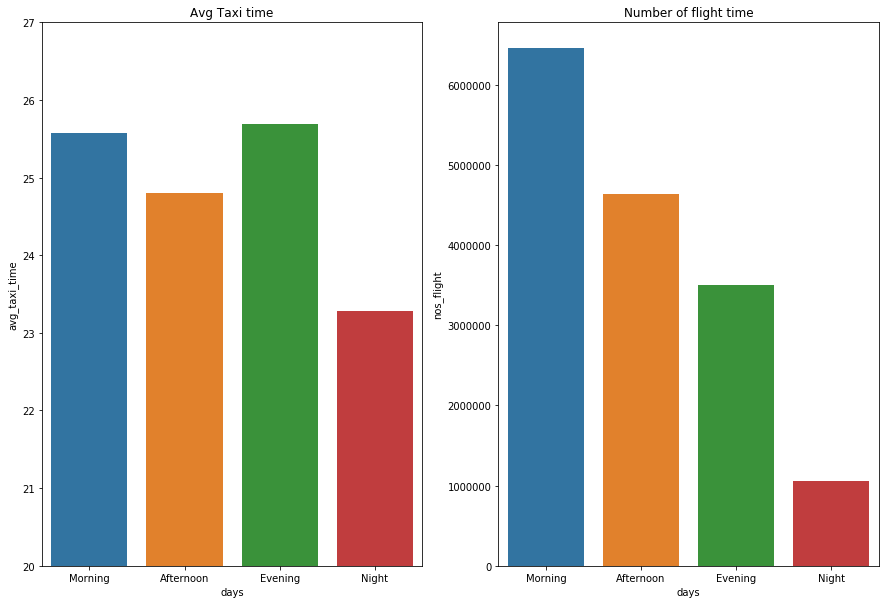

In [184]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
sns.barplot(y='avg_taxi_time',x='days',data=taxi_dt,ax=ax1).set_title('Avg Taxi time')
sns.barplot(y='nos_flight',x='days',data=taxi_dt,ax=ax2).set_title('Number of flight time')
ax1.set_ylim([20, 27])
plt.show();

In [ ]:
a.s

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [185]:
query.execute("""
select dep_delay, arr_delay
from flights 
where dep_delay >0 and arr_delay is not null and dep_delay is not null """)
response_arr = query.fetchall()
cols4 = [column[0] for column in query.description]

In [186]:
arrival_dt=pd.DataFrame(response_arr,columns= cols4)

In [188]:
arrival_dt.head()

,dep_delay,arr_delay
0,22.0,75.0
1,31.0,30.0
2,59.0,96.0
3,13.0,30.0
4,18.0,22.0


In [191]:
gre = arrival_dt[(arrival_dt.arr_delay > arrival_dt.dep_delay)].sample(5,random_state=47)
less = arrival_dt[(arrival_dt.arr_delay < arrival_dt.dep_delay)].sample(5,random_state=47)
equal = arrival_dt[(arrival_dt.arr_delay == arrival_dt.dep_delay)].sample(5,random_state=47)
pd.concat([gre,less,equal],ignore_index=True)
# some have delay departure arrive early

,dep_delay,arr_delay
0,7.0,13.0
1,60.0,68.0
2,8.0,13.0
3,90.0,92.0
4,135.0,149.0
5,5.0,3.0
6,2.0,-15.0
7,10.0,4.0
8,129.0,125.0
9,5.0,-12.0


In [196]:
query.execute("""
select count(*) as arr_less,
(select count(*) from flights where dep_delay >0 and (arr_delay > dep_delay) ) as arr_more,
(select count(*) from flights where dep_delay >0 and (arr_delay = dep_delay)) as arr_equal,
(select count(dep_delay) from flights where dep_delay >0 and arr_delay is not null 
and dep_delay is not null)as total_delay,
(select count(dep_delay)from flights where dep_delay = 0 and arr_delay > 0 and arr_delay is not null 
 and dep_delay is not null) as Exact_time,
(select count(dep_delay)from flights where dep_delay < 0 and arr_delay > 0 
 and arr_delay is not null and dep_delay is not null) as early_departure
from flights
where dep_delay >0 and (arr_delay < dep_delay) """)

response_stat = query.fetchall()
cols5 = [column[0] for column in query.description]

In [197]:
statics_dt=pd.DataFrame(response_stat,columns= cols5)
statics_dt

,arr_less,arr_more,arr_equal,total_delay,exact_time,early_departure
0,3734202,1443656,137785,5315643,198771,1374663


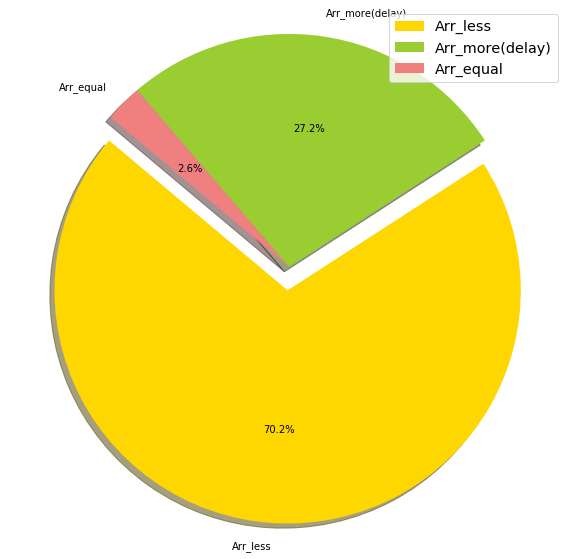

In [204]:
plt.figure(figsize=(10,10))
labels = 'Arr_less', 'Arr_more(delay)', 'Arr_equal'
sizes = [3734202, 1443656, 137785]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0, )  # explode 1st slice

# Plot
patches, *texts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(patches, labels, loc='upper right',fontsize='x-large')
plt.axis('equal')
plt.show()

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?